# Cricket Shot Classification from Images

This notebook demonstrates the image-based cricket shot classification system developed in Sprint 2. It shows how to:

1. Extract pose data from cricket shot images using MediaPipe
2. Calculate joint angles and other biomechanical features from the pose data
3. Train a multiclass LSTM model to classify different cricket shots
4. Evaluate model performance
5. Make predictions on new images

In [13]:
# Import necessary libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import cv2
import torch
from pathlib import Path
from glob import glob
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Add the src directory to the path
sys.path.append('../')

# Import our modules
from src.data_collection.image_pose_extractor import ImagePoseExtractor
from src.feature_engineering.joint_angles import JointAngleCalculator
from src.feature_engineering.dataset_preparer import CricketShotDatasetPreparer
from src.model.multiclass_lstm_model import CricketShotClassifier, CricketShotLSTM

## 1. Configuration

First, let's set up the paths and load the configuration file.

In [14]:
# Set up paths
config_path = "../configs/config.yaml"
data_dir = "../data"
raw_dir = os.path.join(data_dir, "raw")
processed_dir = os.path.join(data_dir, "processed")
models_dir = "../models"
results_dir = "../results"

# Create directories if they don't exist
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

# Load configuration
import yaml

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded successfully.")
print(f"Using {config['data']['pose']['model']} for pose estimation.")
print(f"Model type: {config['model']['type']}")
print(f"Sequence length: {config['model']['sequence_length']} frames")

Configuration loaded successfully.
Using mediapipe for pose estimation.
Model type: lstm
Sequence length: 60 frames


## 2. Exploring the Dataset

Let's explore the image dataset organized by shot type.

Found 6 shot types: ['drive', 'legglance-flick', 'processed', 'pullshot', 'raw', 'sweep']
drive: 1223 images
legglance-flick: 1120 images
processed: 0 images
pullshot: 1260 images
raw: 0 images
sweep: 1120 images


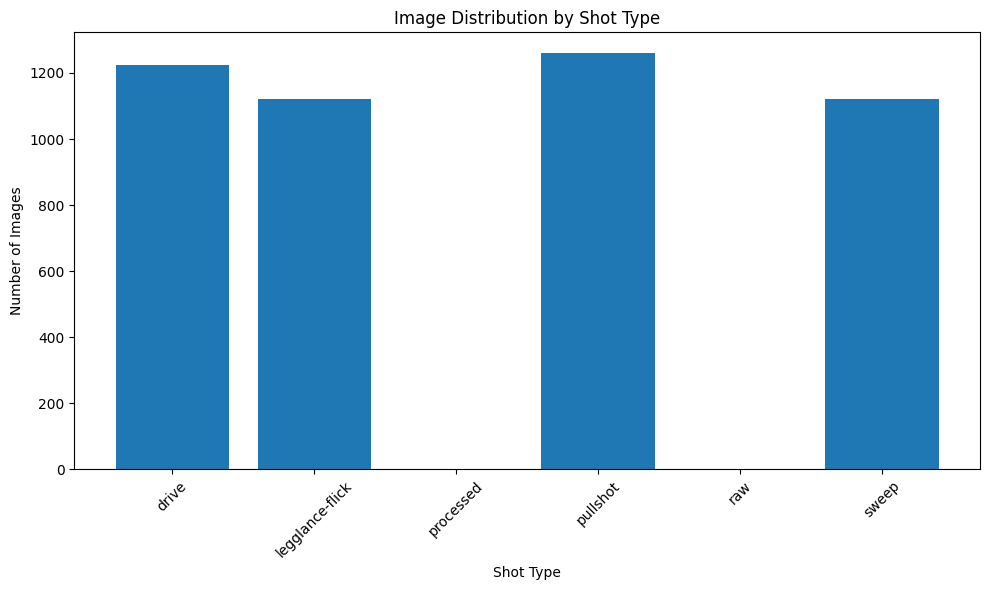

In [15]:
# Define the image data directory
image_data_dir = data_dir

# Get shot types (subdirectories)
shot_types = [d for d in os.listdir(image_data_dir) if os.path.isdir(os.path.join(image_data_dir, d))]

print(f"Found {len(shot_types)} shot types: {shot_types}")

# Count images per shot type
image_counts = {}
for shot_type in shot_types:
    shot_dir = os.path.join(image_data_dir, shot_type)
    image_files = glob(os.path.join(shot_dir, "*.png")) + glob(os.path.join(shot_dir, "*.jpg")) + glob(os.path.join(shot_dir, "*.jpeg"))
    image_counts[shot_type] = len(image_files)

# Display image counts
for shot_type, count in image_counts.items():
    print(f"{shot_type}: {count} images")

# Plot distribution
plt.figure(figsize=(10, 6))
plt.bar(image_counts.keys(), image_counts.values())
plt.title('Image Distribution by Shot Type')
plt.xlabel('Shot Type')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's visualize a few sample images from each shot type.

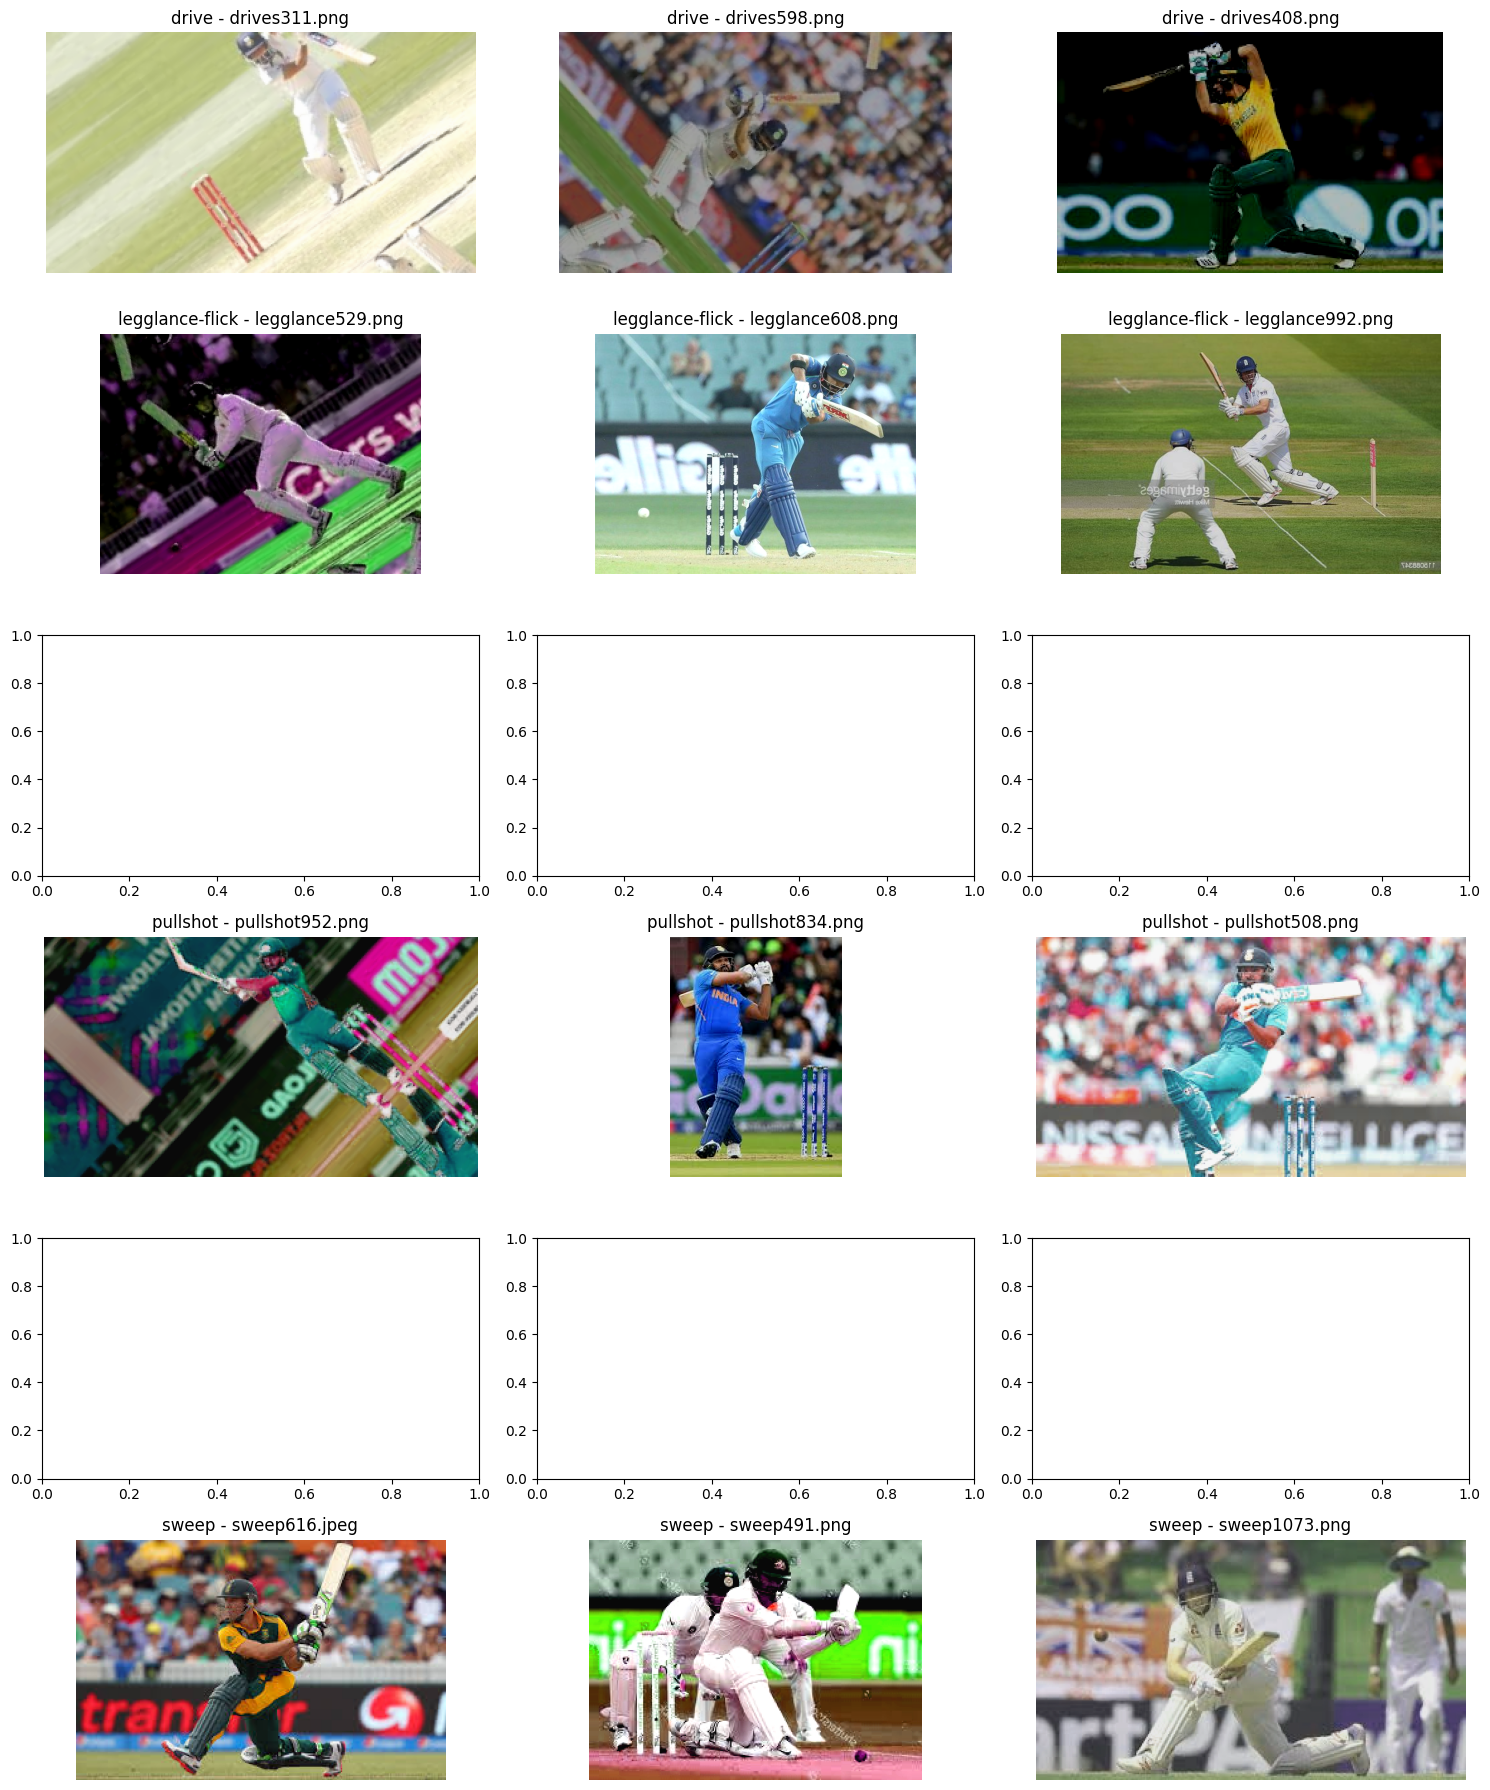

In [16]:
# Display sample images from each shot type
def display_sample_images(shot_types, samples_per_type=3):
    num_types = len(shot_types)
    fig, axes = plt.subplots(num_types, samples_per_type, figsize=(15, 3*num_types))
    
    if num_types == 1:
        axes = [axes]  # Make it 2D for consistent indexing
    
    for i, shot_type in enumerate(shot_types):
        shot_dir = os.path.join(image_data_dir, shot_type)
        image_files = glob(os.path.join(shot_dir, "*.png")) + glob(os.path.join(shot_dir, "*.jpg")) + glob(os.path.join(shot_dir, "*.jpeg"))
        
        # Select random samples
        if len(image_files) > samples_per_type:
            sample_files = np.random.choice(image_files, samples_per_type, replace=False)
        else:
            sample_files = image_files[:samples_per_type]
        
        for j, img_path in enumerate(sample_files):
            if j < samples_per_type:  # Ensure we don't exceed the number of columns
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                axes[i][j].imshow(img)
                axes[i][j].set_title(f"{shot_type} - {os.path.basename(img_path)}")
                axes[i][j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display samples
display_sample_images(shot_types)

## 3. Pose Extraction

Now, let's extract pose landmarks from the cricket shot images using MediaPipe.

In [17]:
# Initialize the pose extractor
pose_extractor = ImagePoseExtractor(config_path)

# Function to extract pose from a single image and visualize it
def extract_and_visualize_pose(image_path, output_dir=None):
    if output_dir is None:
        output_dir = os.path.join(processed_dir, 'poses')
    os.makedirs(output_dir, exist_ok=True)
    
    # Extract pose
    pose_data = pose_extractor.process_image(image_path, output_dir, visualize=True)
    
    # Load the original image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load the visualization image if it exists
    vis_dir = os.path.join(output_dir, 'visualizations')
    vis_path = os.path.join(vis_dir, f"pose_{Path(image_path).stem}.jpg")
    
    if os.path.exists(vis_path):
        vis_image = cv2.imread(vis_path)
        vis_image = cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB)
        
        # Display original and pose visualization side by side
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(image)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
        
        axes[1].imshow(vis_image)
        axes[1].set_title('Pose Landmarks')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"Visualization not found at {vis_path}")
        
    return pose_data

# Extract pose from a sample image from each shot type
for shot_type in shot_types[:2]:  # Limit to first 2 shot types for demonstration
    shot_dir = os.path.join(image_data_dir, shot_type)
    image_files = glob(os.path.join(shot_dir, "*.png")) + glob(os.path.join(shot_dir, "*.jpg")) + glob(os.path.join(shot_dir, "*.jpeg"))
    
    if image_files:
        sample_image = image_files[0]
        print(f"Extracting pose from {shot_type} sample: {os.path.basename(sample_image)}")
        pose_data = extract_and_visualize_pose(sample_image)
        
        # Print number of landmarks detected
        if pose_data['landmarks']:
            print(f"Detected {len(pose_data['landmarks'])} landmarks")
        else:
            print("No landmarks detected")

KeyError: 'pose'

## 4. Feature Engineering

Now, let's calculate joint angles and other biomechanical features from the pose data.

In [18]:
# Initialize the joint angle calculator
angle_calculator = JointAngleCalculator()

# Function to calculate features from pose data
def calculate_features(pose_path):
    # Adapt pose data format for the angle calculator
    with open(pose_path, 'r') as f:
        pose_data = json.load(f)
    
    # Skip if no landmarks
    if not pose_data.get('landmarks'):
        print(f"No landmarks found in {pose_path}, skipping...")
        return None
    
    # The angle calculator expects a specific format with frames
    adapted_pose_data = {
        'frames': [{
            'frame_idx': 0,
            'timestamp': 0,
            'landmarks': pose_data['landmarks']
        }]
    }
    
    # Create a temporary JSON file
    temp_dir = os.path.join(processed_dir, 'temp')
    os.makedirs(temp_dir, exist_ok=True)
    temp_pose_path = os.path.join(temp_dir, f"temp_{Path(pose_path).stem}.json")
    
    with open(temp_pose_path, 'w') as f:
        json.dump(adapted_pose_data, f)
    
    # Calculate joint angles
    features_df = angle_calculator.process_pose_data(temp_pose_path)
    
    # Clean up temporary file
    os.remove(temp_pose_path)
    
    return features_df

# Calculate features for the sample pose files we created earlier
pose_dir = os.path.join(processed_dir, 'poses')
pose_files = glob(os.path.join(pose_dir, "*.json"))

for pose_file in pose_files:
    print(f"Calculating features for {os.path.basename(pose_file)}")
    features_df = calculate_features(pose_file)
    
    if features_df is not None:
        # Display the features
        print("Feature columns:")
        print(features_df.columns.tolist())
        print("Sample features:")
        display(features_df.head())
        
        # Save features
        features_dir = os.path.join(processed_dir, 'features')
        os.makedirs(features_dir, exist_ok=True)
        features_path = os.path.join(features_dir, f"{Path(pose_file).stem}_features.csv")
        features_df.to_csv(features_path, index=False)
        print(f"Saved features to {features_path}")

## 5. Dataset Preparation

Now, let's prepare the dataset for training the LSTM model. We'll use the `CricketShotDatasetPreparer` to process all images, extract poses, calculate features, and create train/validation/test splits.

In [28]:
# Initialize the dataset preparer
dataset_preparer = CricketShotDatasetPreparer(config_path)

# Function to process all images in the dataset
def process_dataset(data_dir, pose_dir, features_dir, subset=None):
    # Create directories
    os.makedirs(pose_dir, exist_ok=True)
    os.makedirs(features_dir, exist_ok=True)
    
    # Initialize the pose extractor
    pose_extractor = ImagePoseExtractor(config_path)
    
    # Get shot types (subdirectories)
    shot_types = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    # Process each shot type
    metadata = []
    
    for shot_type in shot_types:
        shot_dir = os.path.join(data_dir, shot_type)
        image_files = glob(os.path.join(shot_dir, "*.png")) + glob(os.path.join(shot_dir, "*.jpg")) + glob(os.path.join(shot_dir, "*.jpeg"))
        
        # Use subset if specified
        if subset and len(image_files) > subset:
            image_files = np.random.choice(image_files, subset, replace=False)
        
        print(f"Processing {len(image_files)} images for {shot_type}")
        
        for img_path in image_files:
            try:
                # Extract pose
                pose_data = pose_extractor.process_image(img_path, pose_dir, visualize=True)
                
                if pose_data['landmarks']:
                    # Save pose data
                    pose_path = os.path.join(pose_dir, f"{Path(img_path).stem}_pose.json")
                    with open(pose_path, 'w') as f:
                        json.dump(pose_data, f)
                    
                    # Add to metadata
                    metadata.append({
                        'image_path': img_path,
                        'pose_path': pose_path,
                        'class': shot_type
                    })
                else:
                    print(f"No landmarks detected in {img_path}, skipping...")
            except Exception as e:
                print(f"Error processing {img_path}: {e}")
    
    # Save metadata
    metadata_path = os.path.join(pose_dir, "metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Saved metadata for {len(metadata)} images to {metadata_path}")
    
    # Process pose files to extract features
    processed_metadata = dataset_preparer.process_pose_files(metadata_path, features_dir)
    
    # Combine features
    combined_features_path = os.path.join(features_dir, "combined_features.csv")
    combined_df = dataset_preparer.combine_features(processed_metadata, combined_features_path)
    
    # Prepare train/test split
    train_df, val_df, test_df = dataset_preparer.prepare_train_test_split(combined_df)
    
    # Save splits
    splits_dir = os.path.join(features_dir, "splits")
    paths = dataset_preparer.save_splits(train_df, val_df, test_df, splits_dir)
    
    return paths

# Process a subset of the dataset for demonstration
pose_dir = os.path.join(processed_dir, 'poses')
features_dir = os.path.join(processed_dir, 'features')

# Uncomment to process the dataset
# paths = process_dataset(image_data_dir, pose_dir, features_dir, subset=5)  # Process 5 images per class
# print("Dataset preparation complete.")
# print(f"Train set: {paths['train_path']} ({len(pd.read_csv(paths['train_path']))} samples)")
# print(f"Validation set: {paths['val_path']} ({len(pd.read_csv(paths['val_path']))} samples)")
# print(f"Test set: {paths['test_path']} ({len(pd.read_csv(paths['test_path']))} samples)")

## 6. Model Training

Now, let's train the multiclass LSTM model on the prepared dataset.

In [ ]:
# Initialize the classifier
classifier = CricketShotClassifier(config_path)

# Function to train the model
def train_model(train_path, val_path, output_dir, model_name="cricket_shot_classifier.pt"):
    # Load data
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    
    # Load class mapping
    class_mapping_path = os.path.join(os.path.dirname(train_path), "class_mapping.json")
    classifier.load_class_mapping(class_mapping_path)
    
    # Prepare data
    X_train, y_train, X_val, y_val = classifier.prepare_data(
        train_df, val_df, label_col='class', sequence_length=1  # For image data
    )
    
    # Build model
    input_size = X_train.shape[2]  # Number of features
    num_classes = len(np.unique(y_train))
    
    model = classifier.build_model(input_size, num_classes)
    
    # Train model
    history = classifier.train(
        X_train, y_train, X_val, y_val,
        batch_size=32,
        epochs=50,  # Reduced for demonstration
        early_stopping=True
    )
    
    # Save model
    os.makedirs(output_dir, exist_ok=True)
    model_path = os.path.join(output_dir, model_name)
    classifier.save_model(model_path)
    
    print(f"Model saved to {model_path}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train')
    plt.plot(history['val_acc'], label='Validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "training_history.png"))
    plt.show()
    
    return model_path

# Uncomment to train the model
# splits_dir = os.path.join(features_dir, "splits")
# train_path = os.path.join(splits_dir, "train.csv")
# val_path = os.path.join(splits_dir, "val.csv")
# 
# model_path = train_model(train_path, val_path, models_dir)

## 7. Model Evaluation

Let's evaluate the trained model on the test set.

In [21]:
# Function to evaluate the model
def evaluate_model(model_path, test_path):
    # Load model
    classifier = CricketShotClassifier(config_path)
    
    # Load metadata to get input size
    metadata_path = Path(model_path).with_suffix('.json')
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    input_size = metadata.get('input_size')
    num_classes = len(metadata.get('classes', metadata.get('class_mapping', {})))
    
    # Load model
    classifier.load_model(model_path, input_size=input_size, num_classes=num_classes)
    
    # Load test data
    test_df = pd.read_csv(test_path)
    
    # Evaluate
    report, cm = classifier.evaluate(test_df, label_col='class')
    
    # Print classification report
    print("Classification Report:")
    print(report)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classifier.label_encoder.classes_,
                yticklabels=classifier.label_encoder.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(model_path), "confusion_matrix.png"))
    plt.show()

# Uncomment to evaluate the model
# splits_dir = os.path.join(features_dir, "splits")
# test_path = os.path.join(splits_dir, "test.csv")
# 
# evaluate_model(model_path, test_path)

## 8. Making Predictions

Finally, let's use the trained model to make predictions on new images.

In [22]:
# Function to predict cricket shot from an image
def predict_shot(model_path, image_path, visualize=True):
    # Load model
    classifier = CricketShotClassifier(config_path)
    
    # Load metadata to get input size
    metadata_path = Path(model_path).with_suffix('.json')
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    input_size = metadata.get('input_size')
    num_classes = len(metadata.get('classes', metadata.get('class_mapping', {})))
    
    # Load model
    classifier.load_model(model_path, input_size=input_size, num_classes=num_classes)
    
    # Extract pose
    pose_extractor = ImagePoseExtractor(config_path)
    temp_dir = os.path.join(processed_dir, 'temp')
    os.makedirs(temp_dir, exist_ok=True)
    
    pose_data = pose_extractor.process_image(image_path, temp_dir, visualize=visualize)
    
    if not pose_data['landmarks']:
        print(f"No landmarks detected in {image_path}")
        return None
    
    # Save pose data
    pose_path = os.path.join(temp_dir, f"{Path(image_path).stem}_pose.json")
    with open(pose_path, 'w') as f:
        json.dump(pose_data, f)
    
    # Calculate features
    angle_calculator = JointAngleCalculator()
    
    # Adapt pose data format for the angle calculator
    adapted_pose_data = {
        'frames': [{
            'frame_idx': 0,
            'timestamp': 0,
            'landmarks': pose_data['landmarks']
        }]
    }
    
    # Create a temporary JSON file
    temp_pose_path = os.path.join(temp_dir, f"temp_{Path(image_path).stem}.json")
    with open(temp_pose_path, 'w') as f:
        json.dump(adapted_pose_data, f)
    
    # Calculate joint angles
    features_df = angle_calculator.process_pose_data(temp_pose_path)
    
    # Make prediction
    prediction, confidence = classifier.predict(features_df)
    
    # Clean up temporary files
    os.remove(temp_pose_path)
    
    # Visualize if requested
    if visualize:
        # Load the original image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load the visualization image
        vis_dir = os.path.join(temp_dir, 'visualizations')
        vis_path = os.path.join(vis_dir, f"pose_{Path(image_path).stem}.jpg")
        
        if os.path.exists(vis_path):
            vis_image = cv2.imread(vis_path)
            vis_image = cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB)
            
            # Add prediction text
            font = cv2.FONT_HERSHEY_SIMPLEX
            text = f"Prediction: {prediction}"
            conf_text = f"Confidence: {confidence:.2f}"
            
            # Create a copy for adding text
            result_image = vis_image.copy()
            
            # Add text background
            cv2.rectangle(result_image, (10, 10), (300, 70), (255, 255, 255), -1)
            
            # Add text
            cv2.putText(result_image, text, (20, 40), font, 0.8, (0, 0, 0), 2)
            cv2.putText(result_image, conf_text, (20, 60), font, 0.6, (0, 0, 0), 2)
            
            # Display original and result side by side
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            axes[0].imshow(image)
            axes[0].set_title('Original Image')
            axes[0].axis('off')
            
            axes[1].imshow(result_image)
            axes[1].set_title(f'Predicted: {prediction} ({confidence:.2f})')
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.show()
    
    return prediction, confidence

# Uncomment to make predictions on sample images
# model_path = os.path.join(models_dir, "cricket_shot_classifier.pt")
# 
# # Select a few test images
# for shot_type in shot_types[:2]:  # Test with first 2 shot types
#     shot_dir = os.path.join(image_data_dir, shot_type)
#     image_files = glob(os.path.join(shot_dir, "*.png")) + glob(os.path.join(shot_dir, "*.jpg")) + glob(os.path.join(shot_dir, "*.jpeg"))
#     
#     if image_files:
#         # Select a random image that wasn't used in training
#         test_image = np.random.choice(image_files)
#         print(f"Predicting shot for {os.path.basename(test_image)} (true class: {shot_type})")
#         
#         prediction, confidence = predict_shot(model_path, test_image)
#         
#         if prediction:
#             print(f"Predicted: {prediction} with confidence {confidence:.2f}")
#             print(f"Correct: {prediction == shot_type}")

## 9. Conclusion

In this notebook, we've demonstrated the complete workflow for the image-based cricket shot classification system developed in Sprint 2:

1. **Data Exploration**: We explored the dataset of cricket shot images organized by shot type.
2. **Pose Extraction**: We used MediaPipe to extract pose landmarks from cricket shot images.
3. **Feature Engineering**: We calculated joint angles and other biomechanical features from the pose data.
4. **Dataset Preparation**: We prepared the dataset for training, including train/validation/test splits.
5. **Model Training**: We trained a multiclass LSTM model to classify different cricket shots.
6. **Model Evaluation**: We evaluated the model's performance on the test set.
7. **Making Predictions**: We used the trained model to make predictions on new images.

This system provides a foundation for cricket shot analysis from static images, which can be used for technique assessment, coaching, and player development.

## 10. Next Steps (Sprint 3)

For Sprint 3, we plan to extend this system with the following features:

1. **Real-time Classification**: Extend the system to work with live video feeds
2. **Advanced Feedback**: Implement specific technique correction suggestions
3. **Performance Optimization**: Further reduce model size and inference time
